# Projeto Final - KDD - Uni7

## Equipe

* Igor 
* Dantas
* Pedro
* Mateus

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline
sns.set_style(style = 'darkgrid')

### 1. Importe o data set train_call_data e considere a variável alvo 'Event Clearance Description'(0,5 pontos)

In [2]:
trainset = pd.read_csv('input/train_call_data_v1.csv')

In [3]:
testset = pd.read_csv('input/test_call_data.csv')

In [4]:
testset.head(2)

,Unnamed: 0,CAD Event Number,Event Clearance Description,Call Type,Priority,Initial Call Type,Final Call Type,Original Time Queued,Arrived Time,Precinct,Sector,Beat
0,450000,2010000276308,REPORT WRITTEN (NO ARREST),911,2,PROPERTY - DAMAGE,--PROPERTY DEST (DAMG),08/09/2010 03:48:41 AM,Aug 9 2010 03:52:17:000AM,NORTH,NORA,N1
1,450003,2010000276311,UNABLE TO LOCATE INCIDENT OR COMPLAINANT,"TELEPHONE OTHER, NOT 911",4,"NOISE - DIST, GENERAL (CONST, RESID, BALL PLAY)",--DISTURBANCE - NOISE,08/09/2010 03:54:00 AM,Aug 9 2010 07:21:54:000AM,EAST,GEORGE,G1


In [5]:
trainset['dataset'] = 'train'
testset['dataset'] = 'test'

In [6]:
trainset.drop(columns = ['Unnamed: 0'], inplace = True) #  limpa coluna indice
testset.drop(columns = ['Unnamed: 0'], inplace = True) #  limpa coluna indice

In [7]:
data = pd.concat([trainset, testset], axis = 0)

**Alvo**: Event Clearance Description

In [8]:
target_encoder = LabelEncoder()
target_encoder.fit(data['Event Clearance Description'])

data['target'] = target_encoder.transform(data['Event Clearance Description'])

In [9]:
#y = data['Event Clearance Description'] #  Pega variável alvo

### 1.1 Como está o balanceamento das Classes?

In [10]:
proportion = pd.DataFrame(data['Event Clearance Description'].value_counts()/data.shape[0] * 100)\
                                                             .reset_index()\
                                                             .rename(columns = {'index': 'Event', 'Event Clearance Description': 'Percentage'})

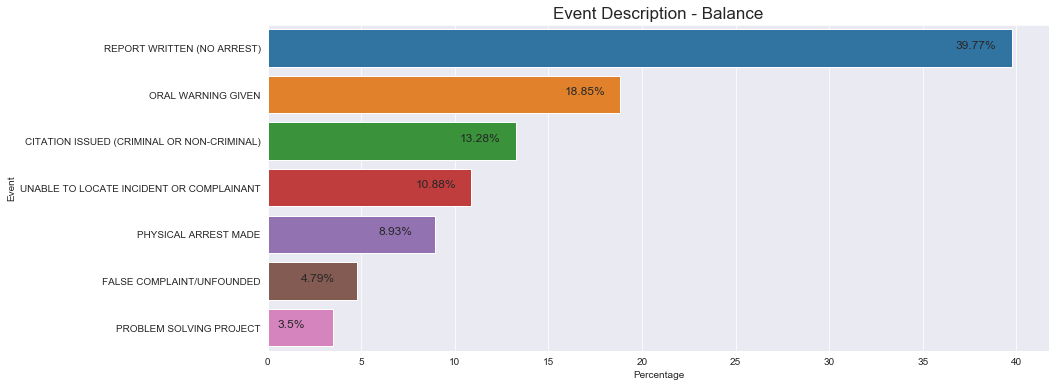

In [11]:
g = sns.barplot(y = 'Event', x = 'Percentage', data = proportion, ax = plt.subplots(figsize = (14, 6))[1])
g.set_title('Event Description - Balance', fontsize = 17)

for i, perct in enumerate(proportion['Percentage'].values):
    g.text(perct - 3, i, str(round(perct, 2)) + '%', fontsize = 12)

In [12]:
data.drop(columns = ['Event Clearance Description'], inplace = True)

### 2. Realize o EDA que você julgar necessário (análise exploratória dos dados), o objetivo do EDA é mostrar alguns insights sobre os dados (1,0 pontos)

#### 2.1 Check missing data

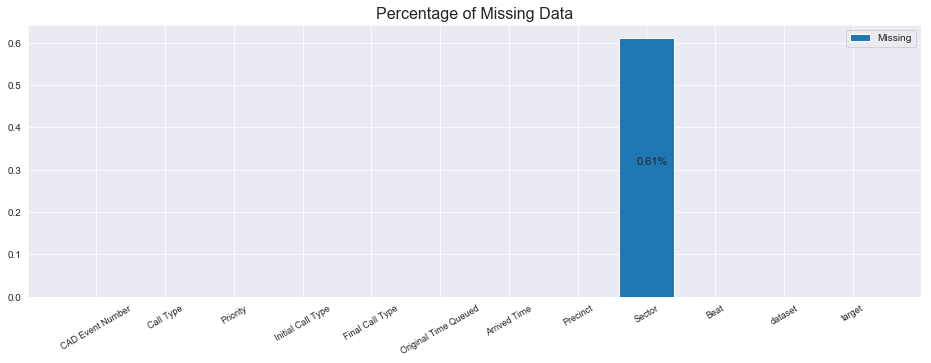

In [13]:
features = (data.isnull().sum()/data.shape[0] * 100).index.tolist()

plt.figure(figsize = (16, 5))
plt.bar(features, data.isnull().sum()/data.shape[0] * 100, label = 'Missing')
plt.xticks(features, fontsize=9, rotation=30)
plt.legend()
plt.title('Percentage of Missing Data', fontsize = 16)

for i, value in enumerate(data.isnull().sum()/data.shape[0] * 100):
    if value > 0:
        plt.text(i - 0.15, value - 0.3, f'{str(round(value, 2))}%', fontsize = '11')


#### 2.2 EDA in Categorical Features

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116997 entries, 0 to 23094
Data columns (total 12 columns):
CAD Event Number        116997 non-null int64
Call Type               116997 non-null object
Priority                116997 non-null int64
Initial Call Type       116997 non-null object
Final Call Type         116997 non-null object
Original Time Queued    116997 non-null object
Arrived Time            116997 non-null object
Precinct                116997 non-null object
Sector                  116281 non-null object
Beat                    116997 non-null object
dataset                 116997 non-null object
target                  116997 non-null int32
dtypes: int32(1), int64(2), object(9)
memory usage: 11.2+ MB


In [15]:
data['Initial Call Type'] = data['Initial Call Type'].apply(lambda x: x.replace('-', '').replace(',', '').replace('.', '').replace('(', '').replace(')', '').replace('  ', ' '))
data['Final Call Type'] = data['Final Call Type'].apply(lambda x: x.replace('-', '').replace(',', '').replace('.', '').replace('(', '').replace(')', '').replace('  ', ' '))

In [16]:
#pd.DataFrame((data['Initial Call Type'].value_counts()/data['Initial Call Type'].shape[0] * 100))

In [17]:
initial = pd.DataFrame((data['Initial Call Type'].value_counts()/data['Initial Call Type'].shape[0] * 100) < 0.5).reset_index()
other = initial[initial['Initial Call Type'] == True]['index'].values
index_ = data[data['Initial Call Type'].isin(other)].index
data.loc[index_, 'Initial Call Type'] = 'OTHER'

In [18]:
final = pd.DataFrame((data['Final Call Type'].value_counts()/data['Final Call Type'].shape[0] * 100) < 0.5).reset_index()
other = final[final['Final Call Type'] == True]['index'].values
index_ = data[data['Final Call Type'].isin(other)].index
data.loc[index_, 'Final Call Type'] = 'OTHER'

In [19]:
# auxiliar features to extract the intersect labels between initial and first
data['initial_list'] = data['Initial Call Type'].apply(lambda x: x.split())
data['final_list'] = data['Final Call Type'].apply(lambda x: x.split())

In [20]:
def rate_intersect_list(initial, final):
    intersect = np.intersect1d(initial, final)
    return intersect.shape[0]/np.union1d(initial, final).shape[0] * 100

In [21]:
data['initial_isEqual_final'] = data[['initial_list', 'final_list']].apply(lambda values: rate_intersect_list(*values), axis = 1)

In [22]:
data.drop(columns = ['initial_list', 'final_list'], inplace = True)

In [23]:
#data.drop(columns = ['Initial Call Type', 'Final Call Type'], inplace = True)

##### Call Type

In [24]:
aux = pd.DataFrame((data['Call Type'].value_counts()/data.shape[0] * 100) < 10).reset_index()
other = aux[aux['Call Type'] == True]['index'].values
index_ = data[data['Call Type'].isin(other)].index
data.loc[index_, 'Call Type'] = 'OTHER'

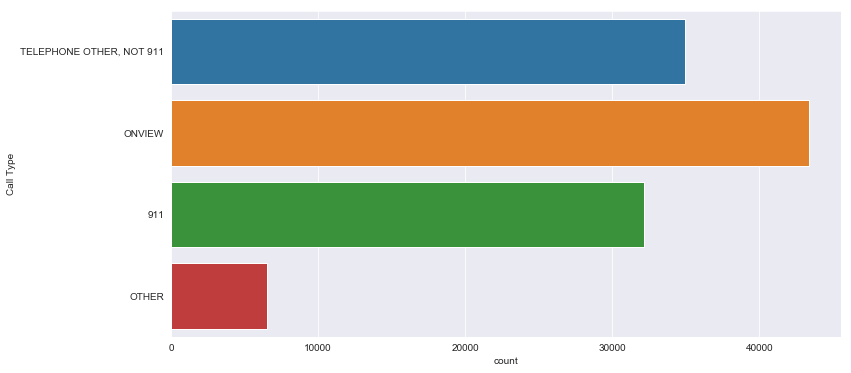

In [25]:
sns.countplot(y = data['Call Type'], ax = plt.subplots(figsize = (12, 6))[1])

##### Priority and Sector

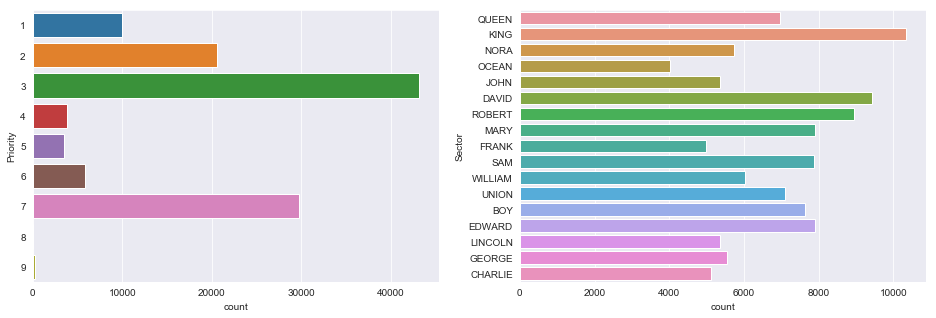

In [26]:
fig, ax = plt.subplots(ncols = 2, figsize = (16, 5))
sns.countplot(y = 'Priority', ax = ax[0], data = data)
sns.countplot(y = 'Sector', ax = ax[1], data = data)
#g.text()

In [27]:
data['Priority'] = data['Priority'].astype('object')

In [28]:
index_ = data[data['Priority'].isin(['8', '9'])].index
data.loc[index_, 'Priority'] = data['Priority'].mode().values[0]

##### Precint

In [29]:
precint = pd.DataFrame(round(data['Precinct'].value_counts()/data.shape[0] * 100, 2))

Text(0.5,1,'Precint - Pizza')

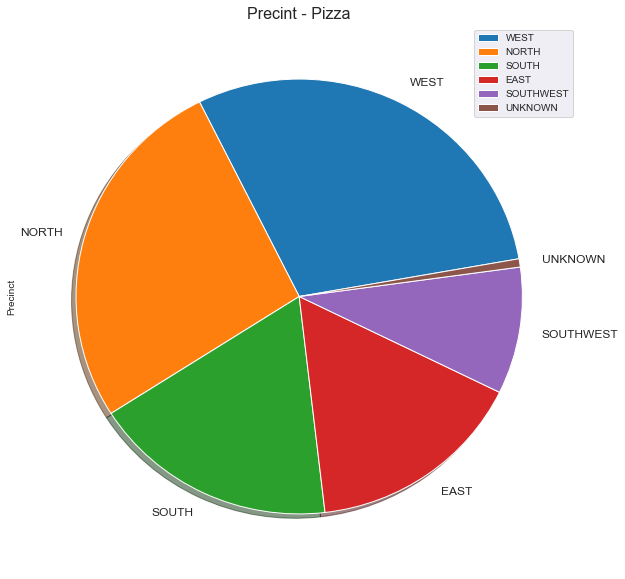

In [30]:
p = precint.plot.pie(y ='Precinct', startangle = 10, ax = plt.subplots(figsize = (10, 10))[1], fontsize = 12, shadow = True)
p.set_title('Precint - Pizza', fontsize = 16)

##### Beat

In [31]:
print(f"There are {data['Beat'].nunique()} categories in feature Beat")

There are 82 categories in feature Beat


In [32]:
beat = pd.DataFrame((data['Beat'].value_counts()/data.shape[0] * 100)).reset_index()
other = beat[beat['Beat'] < 0.5]['index'].values

In [33]:
index_ = data[data['Beat'].isin(other)].index
data.loc[index_, 'Beat'] = 'OTHER'

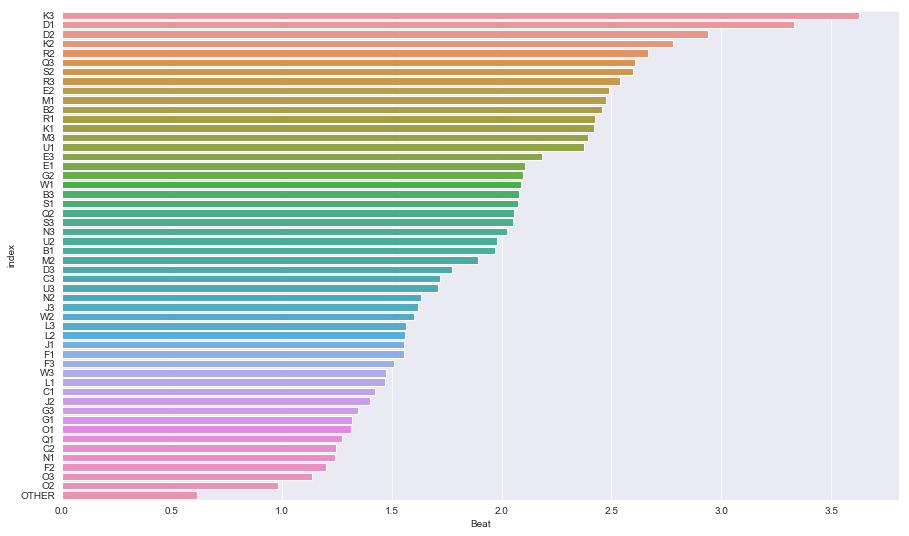

In [34]:
beat = pd.DataFrame((data['Beat'].value_counts()/data.shape[0] * 100)).reset_index()
g = sns.barplot(y = 'index', x = 'Beat', data = beat, ax = plt.subplots(figsize = (15, 9))[1])

## 3. Realize o tratamento que você julgar mais adequado aos dados. (2,0 pontos)

**Explique, com suas palavras, porque o processo de feature engineering é necessário**: 

> A utilização do feature engineering possibilita utilizarmos o conhecimento que temos dos dados, para criarmos recursos que irão facilitar e tornar mais eficiente, o nosso algoritmo. Nesse caso em específico, podemos citar a extração do horário nas colunas original time queued e arrived time e em seguida a subtração entre elas, pois observamos que a informações dos horários são bem mais relevantes ao entendimento do modelo.

### 3.1 Transformar as colunas com informações de data e hora.

In [35]:
import datetime

In [36]:
def month_number(month):
    return ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'].index(month) + 1

def process_date(arrived_date):
    time = None
    try:
        month, _, day, year, time = arrived_date.split(' ')
    except:
        month, day, year, time = arrived_date.split(' ')
    hour, minutes, sec = time.split(':')[:-1]
    return datetime.datetime(int(year), month_number(month), int(day), int(hour), int(minutes), int(sec))

`duration_time`: difference, in minutes, between `original time queued` and `arrived time`

In [37]:
data['Arrived Time'] = data['Arrived Time'].apply(lambda x: process_date(x))
data['Original Time Queued'] = pd.to_datetime(data['Original Time Queued'])
data['duration_time'] = (data['Arrived Time'] - data['Original Time Queued']).apply(lambda time: time.total_seconds()/60)

#### 3.2 Creating a new feature to set the period of the day

In [38]:
def get_part_of_day(queued_date):
    hour = queued_date.hour
    return (
        "morning" if 5 <= hour <= 11
        else
        "afternoon" if 12 <= hour <= 17
        else
        "evening" if 18 <= hour <= 22
        else
        "night"
)

In [39]:
data['Day_Period'] = data['Original Time Queued'].apply(lambda daytime: get_part_of_day(daytime))

#### Dropping some unusal features

In [40]:
delete_columns = ['CAD Event Number', 'Original Time Queued', 'Arrived Time']
data.drop(columns = delete_columns, inplace = True)

#### 3.3 Setting to zero the negative duration

In [41]:
index_ = data[data['duration_time'] < 0].index
data.loc[index_, 'duration_time'] = 0

In [42]:
data['duration_time'] = MinMaxScaler().fit_transform(data[['duration_time']])

#### 3. Creating Dummy Features and Scaling

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116997 entries, 0 to 23094
Data columns (total 12 columns):
Call Type                116997 non-null object
Priority                 116997 non-null int64
Initial Call Type        116997 non-null object
Final Call Type          116997 non-null object
Precinct                 116997 non-null object
Sector                   116281 non-null object
Beat                     116997 non-null object
dataset                  116997 non-null object
target                   116997 non-null int32
initial_isEqual_final    116997 non-null float64
duration_time            116997 non-null float64
Day_Period               116997 non-null object
dtypes: float64(2), int32(1), int64(1), object(8)
memory usage: 13.7+ MB


##### Get the categorical and numerical features

In [44]:
numeric_features = data.select_dtypes(include = ['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).drop(['dataset'], axis=1).columns

In [45]:
data[categorical_features] = data[categorical_features].astype('category')

### 4. Selecione duas soluções candidatas e justifique suas escolhas. Mostre os pontos negativos e positivos de cada modelo. (2,0 pontos)

* *Support Vector Machine*:
> ***Pontos Positivos***: 
              * Boa capacidade de generalização; 
              * Robusta diante de dados de grande dimensão, sobre os quais outras técnicas de aprendizado normalmente obtêm classificadores super ou sub ajustados; 
              * O processo de classificação é rápido; 
              * Convexidade do problema de otimização formulado em seu treinamento, que implica na existência de um único mínimo global.
> ***Pontos negativos***: 
              * É necessário definir um bom Kernel; 
              * A sensibilidade a escolhas de valores de parâmetros e a dificuldade de interpretação do modelo gerado; 
              * O tempo de treinamento pode ser bem longo dependendo do número de exemplos e dimensionalidade dos dados.

* *Random Forest*: Devido os dados serem categóricos, seria interessante criar um modelo baseado em árvore.
> ***Pontos positivos***: 
              * Alta velocidade de aprendizagem;
              * Aprendizado não iterativo — o algoritmo é concluído em um número fixo de operações;
              * Escalabilidade - capacidade de lidar com grandes quantidades de dados;
              * Alta qualidade dos modelos obtidos;
              * Baixa sensibilidade aos picos nos dados devido a amostragem aleatória;  
              * Poucos parâmetros configuráveis, e que não exigem tantos cuidados;
              * Sem sensibilidade ao dimensionamento dos valores das características e a qualquer transformação monótona em geral, devido à seleção de subespaços aleatórios;
              * Funciona bem com dados ausentes — mantém uma boa precisão, mesmo que uma grande parte dos dados estejam ausentes;
              * Avaliação interna da capacidade de generalização do modelo;
              * Capacidade de trabalhar com dados brutos, sem pré-processamento.
> ***Pontos negativos***: 
              * O modelo construído ocupa uma grande quantidade de memória. No entanto, como a quantidade de RAM nos computadores modernos é grande o suficiente, isso cada vez mais, deixa de ser um problema;
              * Um modelo treinado funciona um pouco mais lento do que outros algoritmos, devido a iteração em todas as árvores. Assim como o item anterior, o aumento do recurso das máquinas faz com que esse problema sema minimizado;
              * O algoritmo funciona pior do que a maioria dos métodos lineares quando um conjunto tem muitas características esparsas (textos, bag de palavras) ou quando os objetos a serem classificados podem ser separados linearmente;
              * O algoritmo é propenso a overfitting, especialmente em tarefas com muito ruído. Parte deste problema pode ser resolvido ajustando o parâmetro r;
              * Para dados que incluem variáveis ​​categóricas com um número diferente de níveis, as florestas aleatórias são inclinadas em favor de características com mais níveis. Uma árvore será mais fortemente ajustada a tais características, pois elas permitem receber um valor maior de funcionalidade otimizada (tipo de ganho de informação).
              * O algoritmo é absolutamente incapaz de extrapolação, mas isso podeser considerado uma vantagem, já que não haverá valores extremos no caso de um pico.

### 5. Construa os modelos de aprendizagem de máquina para cada modelo (2,0 ponto)

**OBS**: sklearn version 0.21.1

In [46]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

In [47]:
from scipy.stats import chi2_contingency

Does some column have statistical significancy ? If not, I will drop it! xD

In [48]:
for col in data.columns:
    if col != 'dataset':
        _, alpha, _, _ = chi2_contingency(pd.crosstab(data['Beat'], data['target']))
        print(f"Alpha in {col}: {alpha}")

Alpha in Call Type: 0.0
Alpha in Priority: 0.0
Alpha in Initial Call Type: 0.0
Alpha in Final Call Type: 0.0
Alpha in Precinct: 0.0
Alpha in Sector: 0.0
Alpha in Beat: 0.0
Alpha in target: 0.0
Alpha in initial_isEqual_final: 0.0
Alpha in duration_time: 0.0
Alpha in Day_Period: 0.0


#### 5.1 Pipelines:

In [49]:
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler() )])
categorical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='constant', fill_value='missing')),
                                          ('dummy_encoder', OrdinalEncoder()),
                                          ('dummy_features', OneHotEncoder( handle_unknown = 'ignore'
                                                                            #drop = 'first'
                                                                          )
                                              )
                                         ]
                                    )

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                              ('cat', categorical_transformer, categorical_features)])
naive_bayes = Pipeline(steps=[('preprocessor',preprocessor),
                         ('classifier',MultinomialNB())])

random_forest = Pipeline(steps=[('preprocessor',preprocessor),
                         ('classifier',RandomForestClassifier())])

In [50]:
# resetting the train and test dataset
trainset = data[data['dataset'] == 'train'].copy()
testset  = data[data['dataset'] == 'test'].copy()

trainset.drop(columns=['dataset'], inplace=True)
testset.drop(columns=['dataset'], inplace=True)

In [51]:
# set X and y data
X, y = trainset[trainset.columns.difference(['target'])], trainset['target'],

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, stratify = trainset['target'], random_state = 100)

##### Naive Bayes

In [53]:
naive_bayes.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  Index(['Priority', 'initial_isEqual_final', 'duration_time'], dtype='object')),
                                                 ('cat',
  

In [54]:
print("Naive Bayes score: ", naive_bayes.score(X_val, y_val))

Naive Bayes score:  0.7269532497958894


##### Random Forest

In [55]:
random_forest.fit(X_train, y_train)

C:\Users\igor_sousa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  Index(['Priority', 'initial_isEqual_final', 'duration_time'], dtype='object')),
                                                 ('cat',
  

In [56]:
print("Random Forest score: ", random_forest.score(X_val, y_val))

Random Forest score:  0.7313904369741934


### 6. Para cada modelo aplique uma combinação aos hiperparâmetros com o GridSearch e aplique também o CrossValidation

In [57]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [58]:
stratify_fold = StratifiedKFold(n_splits = 5, shuffle = True)

In [59]:
naive_params = {
    #'classifier__alpha ': [1.0],
    'classifier__fit_prior': [True, False]
}

random_forest_params = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': np.arange(5, 50, 10),
    'classifier__n_jobs': [-1],
    'classifier__oob_score': [True],
    'classifier__class_weight': ['balanced_subsample']
}

### 7. Defina uma métrica de avaliação e avalie as soluções candidatas. Justifique a escolha da sua métrica. (1,0 ponto)

Métrica: `accuracy`
> Explicar o motivo...

##### Naive Bayes - GridSearch 

In [60]:
naive_grid = GridSearchCV(naive_bayes, naive_params, cv = stratify_fold, n_jobs = -1, verbose = 0, scoring = 'accuracy')

In [61]:
naive_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          MinMaxScaler(copy=True,
                                                                           

In [62]:
naive_grid.cv_results_['mean_test_score'].mean()

0.7064018499642482

##### Random Forest - GridSearch

In [63]:
forest_grid = GridSearchCV(random_forest, random_forest_params, cv = stratify_fold, n_jobs = -1, verbose = 0)

In [64]:
forest_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          MinMaxScaler(copy=True,
                                                                           

In [65]:
forest_grid.cv_results_['mean_test_score'].mean()

0.7102919474829228

### 8. Escolha um dos modelos, por exemplo o melhor modelo, e faça uma análise do overfitting e underfitting. Justique sua resposta com base em experimentos. (1,5 pontos)

In [66]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, stratify = X[["Initial Call Type", "Final Call Type"]], random_state = 10)
    train_errors, val_errors = [], []
    
    for m in range(1, X_train.shape[0]):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict   = model.predict(X_val)
        train_errors.append(model.score(y_train_predict, y_train[:m]))
        val_errors.append(model.score(y_val_predict, y_val))
    
    plt.plot(train_errors, "r-+", linewidth = 2, label = 'train')
    plt.plot(val_errors, "b-", linewidth = 3, label = 'test')

In [67]:
#plot_learning_curves(random_forest, X, y)

In [68]:
random_forest.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  Index(['Priority', 'initial_isEqual_final', 'duration_time'], dtype='object')),
                                                 ('cat',
  

### 9. Realize a predição sobre os dado test_call_data, como o seu modelo saiu? (1,0 ponto)

In [69]:
# test data
X_test = data[data['dataset'] == 'test']
y_test = X_test['target'].astype('category')
X_test = X_test.drop(columns=['target', 'dataset'], inplace=False)

In [70]:
for model_name, model in zip(['Naive Bayes', 'Random Forest'], [naive_grid, forest_grid]):
    print(model_name, ':', model.best_estimator_.score(X_test, y_test))

Naive Bayes : 0.6729595150465468
Random Forest : 0.6737822039402468


### 10. Se seu modelo permitir analisar a importância das features, analise-o e tente justificar de forma subjetiva a importância da feature. Por exemplo, a feature_chamadas_a_noite possui um alto coeficiente, pois há uma tendência dos crimes acontecerem a noite, não tão simples assim :P. (1,0 ponto)

### 11. Aplique clusterização, preferencialmente o KMeans sobre o dado, e comunique suas novas descobertas, sinta-se a vontade para apresentar uma solução com recursos visuais (2,0 pontos)